Packages and Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.simplefilter("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Time series analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Machine learning models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# !pip install statsmodels xgboost scikit-learn

## **Reading Data**

In [ ]:
data = '/content/WPI_Data.xlsx'

# Reading the xlsx sheet
df = pd.read_excel(data, sheet_name=1)

print("Data Shape:", df.shape)

print(df.head())

Data Shape: (35, 2)
   Year       WPI
0  1990  204.8580
1  1991  270.5749
2  1992  189.7332
3  1993  191.8816
4  1994  211.5574


# **Exploratory Data Analysis**

### **WPI Over Time - Line Plot**

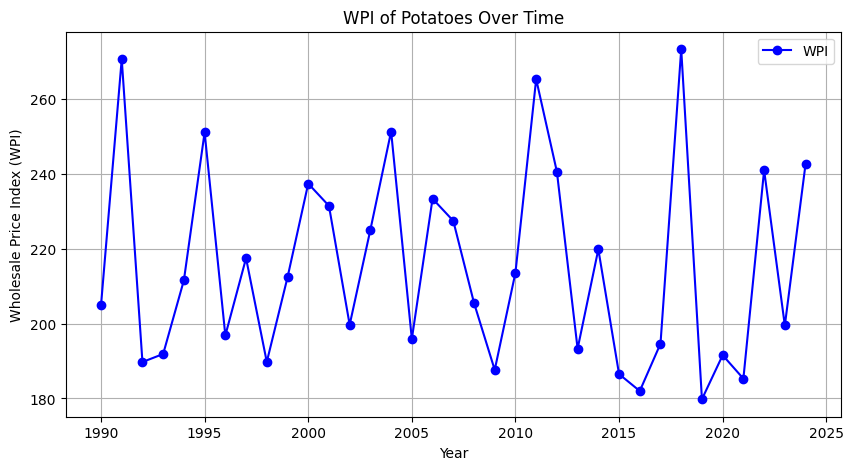

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df["Year"], df["WPI"], marker="o", linestyle="-", color="b", label="WPI")
plt.xlabel("Year")
plt.ylabel("Wholesale Price Index (WPI)")
plt.title("WPI of Potatoes Over Time")
plt.legend()
plt.grid(True)
plt.show()

###**Summary Statistics**

In [ ]:
summary_stats = df["WPI"].describe()
print("Summary Statistics\n", summary_stats)

Summary Statistics
 count     35.000000
mean     215.399546
std       26.836287
min      179.805400
25%      192.578500
50%      211.557400
75%      235.343800
max      273.224300
Name: WPI, dtype: float64


### **Missing Values**

In [ ]:
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Year    0
WPI     0
dtype: int64


### **Box Plot**

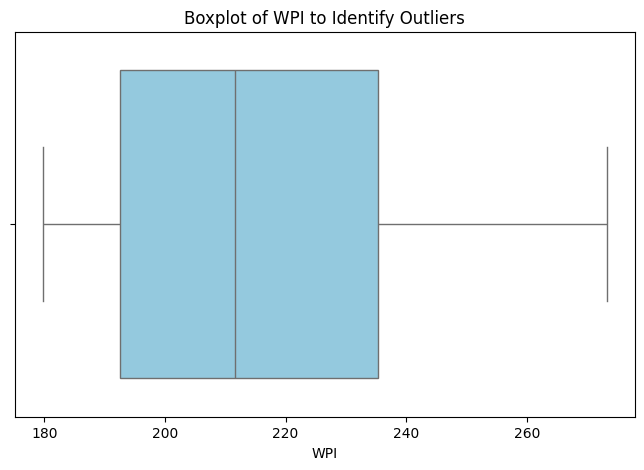

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["WPI"], color="skyblue")
plt.title("Boxplot of WPI to Identify Outliers")
plt.show()

### **ACF and Fourier Analysis**

<Figure size 1000x500 with 0 Axes>

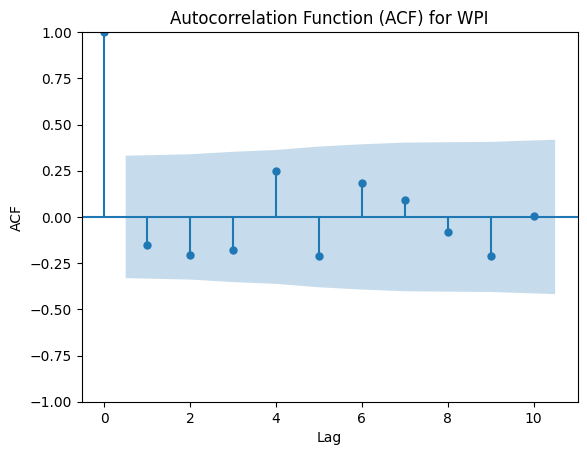

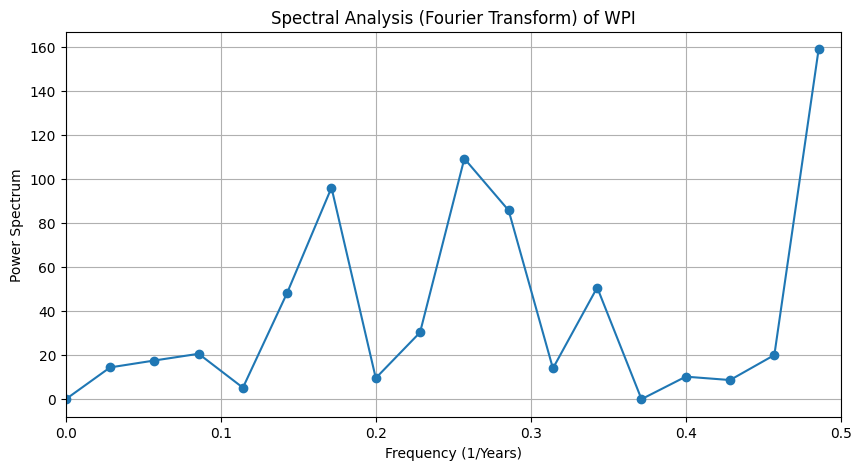

In [ ]:
#ACF Analysis
plt.figure(figsize=(10, 5))
plot_acf(df['WPI'], lags=10)
plt.title("Autocorrelation Function (ACF) for WPI")
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Fourier Analysis
years = df['Year'].values
wpi_values = df['WPI'].values
freqs, power = periodogram(wpi_values, scaling='spectrum')

# Periodogram
plt.figure(figsize=(10, 5))
plt.plot(freqs, power, marker='o', linestyle='-')
plt.xlabel("Frequency (1/Years)")
plt.ylabel("Power Spectrum")
plt.title("Spectral Analysis (Fourier Transform) of WPI")
plt.xlim(0, 0.5)

plt.grid(True)
plt.show()

### **WPI Percentage Change**

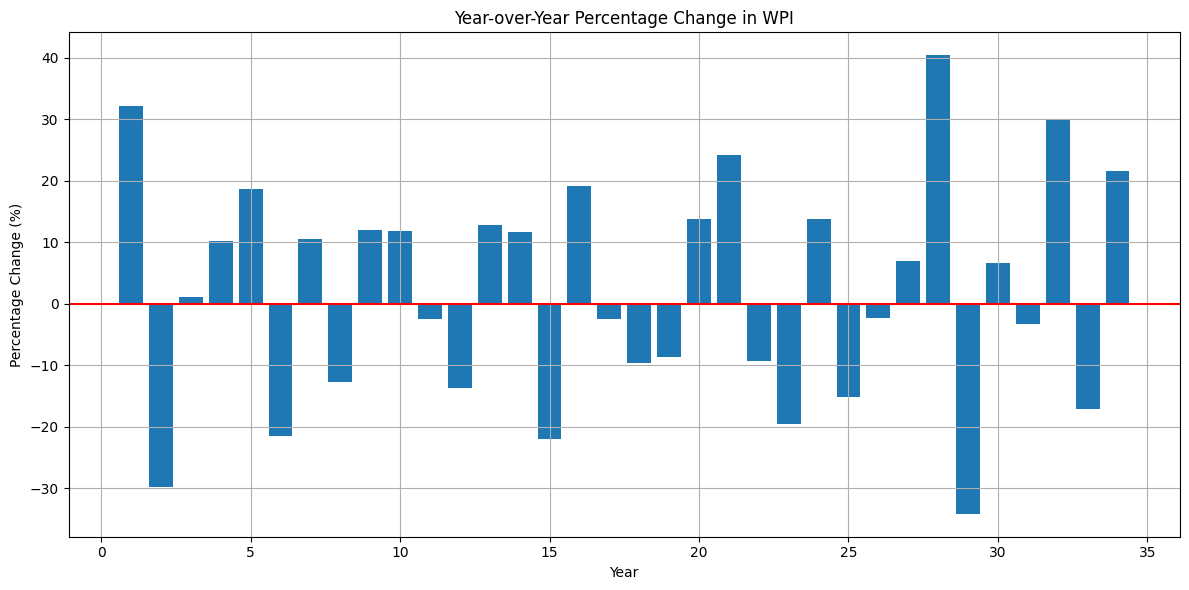

In [ ]:
# Year-over-year changes
yoy_change = df['WPI'].pct_change() * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df.index[1:], yoy_change[1:])
plt.title('Year-over-Year Percentage Change in WPI')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

### **Volatility Analysis of WPI**

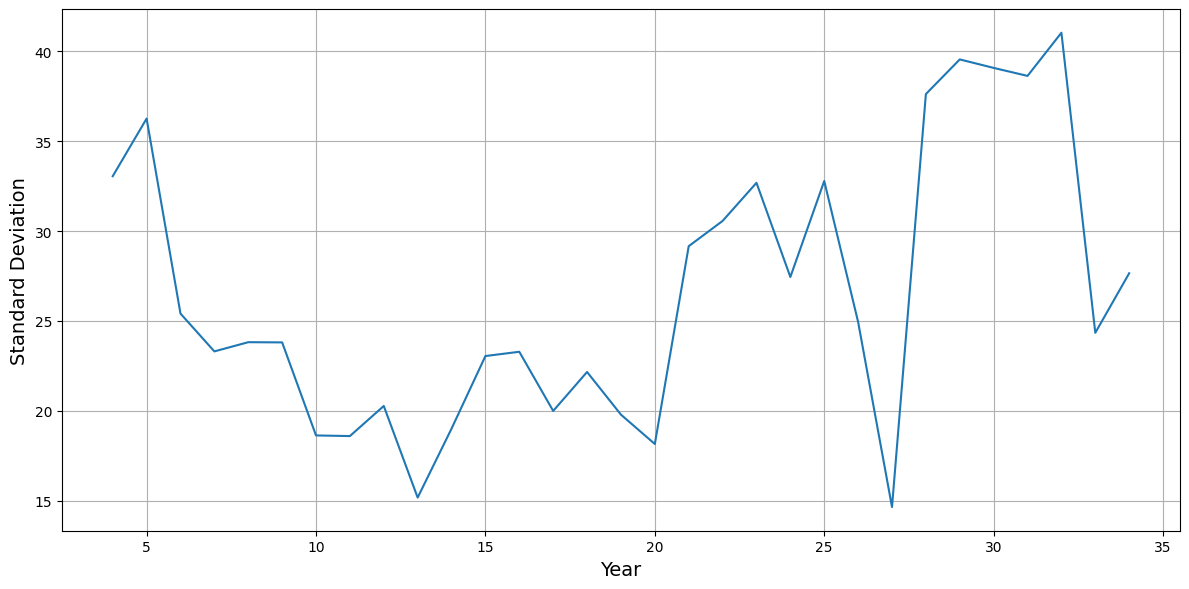

In [ ]:
volatility = df['WPI'].rolling(window=5).std()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index[4:], volatility[4:])
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.show()

### **ADF (Augmented Dickey Fuller Test)**

In [ ]:
# ADF test
result = adfuller(df['WPI'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Stationarity check
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary")

ADF Statistic: -6.54927258778765
p-value: 8.935530000413682e-09
Critical Values: {'1%': np.float64(-3.639224104416853), '5%': np.float64(-2.9512301791166293), '10%': np.float64(-2.614446989619377)}
Data is stationary


## **Analysis and Modelling**

### **Splitting Data**

In [ ]:
df.set_index('Year', inplace=True)

train_data = df['WPI'][:28]  # First 28 years for training
test_data = df['WPI'][28:]   # Remaining 7 years for testing

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

### **ACF and PACF**

<Figure size 1200x500 with 0 Axes>

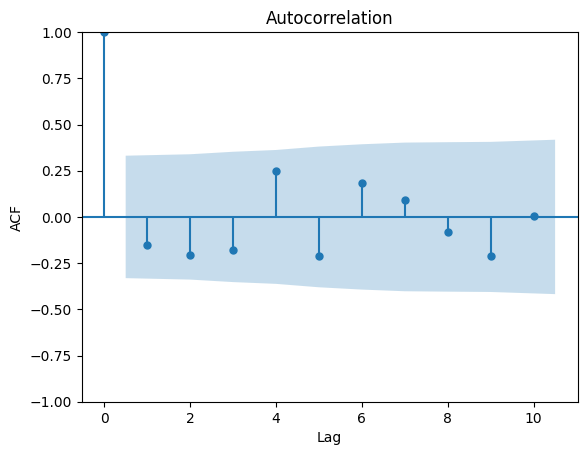

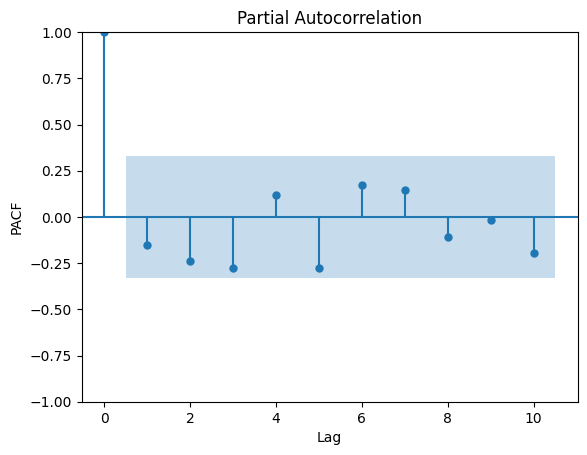

(35, 1)


In [ ]:
plt.figure(figsize=(12,5))
plot_acf(df["WPI"].dropna(), lags=10)
plt.xlabel('Lag')
plt.ylabel('ACF')
plot_pacf(df["WPI"].dropna(), lags=10)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()
print(df.shape)

### **Best ARMA order**

In [ ]:
p_values = range(0, 10)
d_values = [0]  # since it is stationary
q_values = range(0, 9)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_rmse = float('inf')
best_aicc = float('inf')
best_order = None
results = []

# evaluate model
for order in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(train_data, order=order).fit()
        predictions = model.predict(start=len(train_data), end=len(df)-1)
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        aicc = model.aicc

        results.append((order, rmse, aicc))

        if rmse < best_rmse:
            best_rmse = rmse
            best_aicc = aicc
            best_order = order
    except:
        continue

# Best Model
results_df = pd.DataFrame(results, columns=['Order', 'RMSE', 'AICc'])
results_df = results_df.sort_values(by='RMSE')
print(results_df.head())
print(f"Best ARMA Order: {best_order}, RMSE: {best_rmse:.2f}, AICc: {best_aicc:.2f}")
print(df.shape)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

        Order       RMSE        AICc
84  (9, 0, 4)  26.992090  321.031679
37  (4, 0, 1)  27.638417  274.286516
28  (3, 0, 1)  27.957118  270.799734
40  (4, 0, 4)  28.502487  283.928843
71  (7, 0, 8)  29.069121  343.444346
Best ARMA Order: (9, 0, 4), RMSE: 26.99, AICc: 321.03
(35, 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### **ARMA**

In [ ]:
arma_model = ARIMA(train_data, order=(3,0,1))
arma_fit = arma_model.fit()
arma_forecast = arma_fit.predict(start=len(train_data), end=len(df)-1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

### **Checking Seasonality**

In [ ]:
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
s = 1  # since it is yearly

# Generating all combinations of p,d,q
seasonal_combinations = list(itertools.product(P_values, D_values, Q_values))

best_rmse = float('inf')
best_order = (3,0,1)
best_seasonal_order = None

# Loop through combinations
for seasonal_order in seasonal_combinations:
    try:
        model = sm.tsa.SARIMAX(train_data, order=best_order,
                               seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s))
        fit = model.fit()

        predictions = fit.predict(start=len(train_data), end=len(df)-1)
        rmse = np.sqrt(mean_squared_error(test_data, predictions))

        # best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_seasonal_order = seasonal_order

    except:
        continue

print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, RMSE: {best_rmse:.4f}")


Best SARIMA Order: (3, 0, 1), Seasonal Order: None, RMSE: inf


### **Random Forest and XGBoost**

In [ ]:
# Lag Features based on ARMA (3,0,1)
df_lags = df.copy()  # Copy of original data
df_lags['Lag1'] = df_lags['WPI'].shift(1)
df_lags['Lag2'] = df_lags['WPI'].shift(2)
df_lags['Lag3'] = df_lags['WPI'].shift(3)
df_lags.dropna(inplace=True)

print("After lag features:", df_lags.shape)

df_lags.fillna(method="bfill", inplace=True)

# Splitting Data using df_lags
train_size = int(len(df_lags) * 0.8)
train, test = df_lags.iloc[:train_size], df_lags.iloc[train_size:]

# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['WPI', 'Lag1', 'Lag2', 'Lag3']])
test_scaled = scaler.transform(test[['WPI', 'Lag1', 'Lag2', 'Lag3']])

X_train, y_train = train_scaled[:, 1:], train_scaled[:, 0]  # Lag features as X, WPI as y
X_test, y_test = test_scaled[:, 1:], test_scaled[:, 0]

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast_scaled = rf_model.predict(X_test).reshape(-1, 1)
rf_forecast = scaler.inverse_transform(np.hstack((rf_forecast_scaled, X_test)))[:, 0]

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_forecast_scaled = xgb_model.predict(X_test).reshape(-1, 1)
xgb_forecast = scaler.inverse_transform(np.hstack((xgb_forecast_scaled, X_test)))[:, 0]

# RMSE
rmse_rf = np.sqrt(mean_squared_error(test['WPI'], rf_forecast))
rmse_xgb = np.sqrt(mean_squared_error(test['WPI'], xgb_forecast))

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

test['RF_Prediction'] = rf_forecast
test['XGB_Prediction'] = xgb_forecast

df = df[['WPI']]

After lag features: (32, 4)
Random Forest RMSE: 31.78
XGBoost RMSE: 28.92


### **Long Short-Term Memory**

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 3  # Matches ARMA p=3

full_data = df['WPI'].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler()
scaled_data = scaler_lstm.fit_transform(full_data)

# Splitting data
train_size = int(len(full_data) * 0.8)
train_scaled_lstm = scaled_data[:train_size]
test_scaled_lstm = scaled_data[train_size:]

X_train, y_train = create_sequences(train_scaled_lstm, sequence_length)
X_test, y_test = create_sequences(test_scaled_lstm, sequence_length)

print(f"Total data points: {len(full_data)}")
print(f"Train data points: {len(train_scaled_lstm)}")
print(f"Test data points: {len(test_scaled_lstm)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# LSTM model
model = Sequential([
    LSTM(10, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# RMSE
test_predictions = model.predict(X_test, verbose=0)
test_predictions = scaler_lstm.inverse_transform(test_predictions)
y_test_actual = scaler_lstm.inverse_transform(y_test.reshape(-1, 1))
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f'LSTM RMSE: {lstm_rmse}')

Total data points: 35
Train data points: 28
Test data points: 7
X_train shape: (25, 3, 1)
X_test shape: (4, 3, 1)
LSTM RMSE: 36.009556787942365


### **ARMA+LSTM**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

train_data = df['WPI'][:28]
test_data = df['WPI'][28:]

# ARMA model
arma_model = ARIMA(train_data, order=(3, 0, 1))
arma_fit = arma_model.fit()
arma_train_pred = arma_fit.predict(start=0, end=len(train_data) - 1)
arma_forecast = arma_fit.predict(start=len(train_data), end=len(df) - 1)
print(f"arma_forecast length before trimming: {len(arma_forecast)}")
arma_forecast = pd.Series(arma_forecast.values, index=test_data.index)
print(f"arma_forecast length after trimming: {len(arma_forecast)}")
arma_rmse = np.sqrt(mean_squared_error(test_data, arma_forecast))

# scale residuals
train_residuals = train_data - arma_train_pred
scaler_lstm = MinMaxScaler()
train_residuals_scaled = scaler_lstm.fit_transform(train_residuals.values.reshape(-1, 1))

# sequences from scaled residuals
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_train, y_train = create_sequences(train_residuals_scaled, sequence_length)

print(f"Total data points: {len(df)}")
print(f"Train points: {len(train_data)}")
print(f"Test points: {len(test_data)}")
print(f"X_train shape: {X_train.shape}")

# LSTM
model = Sequential([
    LSTM(10, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, shuffle=False,
          callbacks=[early_stopping], verbose=0)

last_sequence = train_residuals_scaled[-sequence_length:]
test_residuals_pred_scaled = []
current_sequence = last_sequence.copy()
for _ in range(len(test_data)):
    current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
    next_pred = model.predict(current_sequence_reshaped, verbose=0)
    test_residuals_pred_scaled.append(next_pred[0, 0])
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_pred[0, 0]

test_residuals_pred = scaler_lstm.inverse_transform(np.array(test_residuals_pred_scaled).reshape(-1, 1))
print(f"test_residuals_pred length: {len(test_residuals_pred)}")

# Combine ARMA with LSTM residuals
hybrid_forecast = arma_forecast + test_residuals_pred.flatten()

# RMSE
ARMA_LSTM_rmse = np.sqrt(mean_squared_error(test_data, hybrid_forecast))

test_residuals_actual = test_data - arma_forecast
print(f"test_residuals_actual length: {len(test_residuals_actual)}")
residual_rmse = np.sqrt(mean_squared_error(test_residuals_actual, test_residuals_pred.flatten()))

print(f'Hybrid ARMA-LSTM RMSE: {ARMA_LSTM_rmse:.4f}')

arma_forecast length before trimming: 7
arma_forecast length after trimming: 7
Total data points: 35
Train points: 28
Test points: 7
X_train shape: (25, 3, 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

test_residuals_pred length: 7
test_residuals_actual length: 7
Hybrid ARMA-LSTM RMSE: 33.9511


### **Conclusion**

In [ ]:
arma_rmse = np.sqrt(mean_squared_error(test_data, arma_forecast))
xgb_rmse = np.sqrt(mean_squared_error(test_data, xgb_forecast))
rf_rmse = np.sqrt(mean_squared_error(test_data, rf_forecast))

rmse_values = [arma_rmse, rmse_rf, rmse_xgb, lstm_rmse, ARMA_LSTM_rmse]
model_names = ["ARMA", "Random Forest", "XGBoost", "LSTM", "ARMA+LSTM"]

# Sorting results
sorted_indices = np.argsort(rmse_values)
print("RMSE Results:\n")
for index in sorted_indices:
    print(f"{model_names[index]}: {rmse_values[index]}")

RMSE Results:

ARMA: 27.957117515957485
XGBoost: 28.92264879310003
Random Forest: 31.784815356517974
ARMA+LSTM: 33.95113451827188
LSTM: 36.009556787942365


### **Actual VS Predicted WPI Values for ARMA**

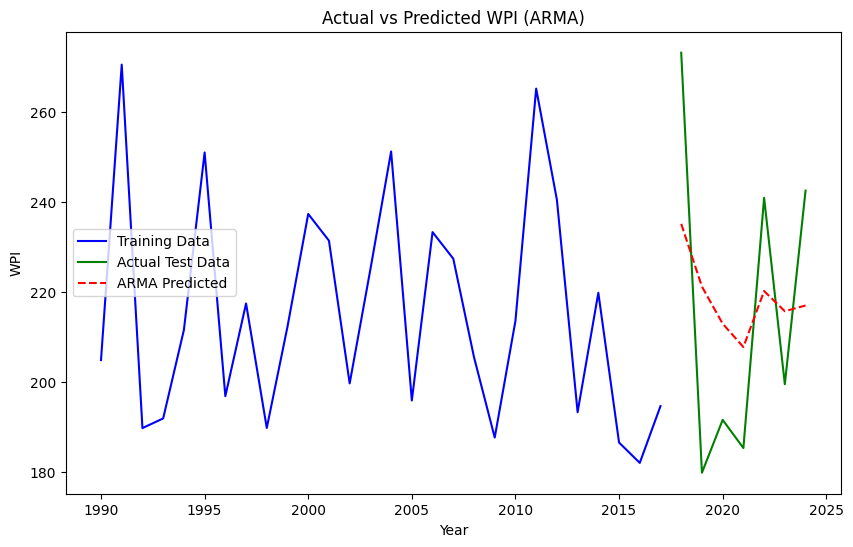

        Actual   Predicted
Year                      
2018  273.2243  235.155273
2019  179.8054  221.198464
2020  191.5618  212.948625
2021  185.2952  207.765255
2022  240.9461  220.214836
2023  199.4930  215.727117
2024  242.5522  216.999611


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
plt.plot(test_data.index, arma_forecast, label='ARMA Predicted', color='red', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('WPI')
plt.title('Actual vs Predicted WPI (ARMA)')
plt.legend()
plt.show()

comparison_df = pd.DataFrame({'Actual': test_data, 'Predicted': arma_forecast})
print(comparison_df)

### **Predicted Values of All Models VS Actual Values of Test Data**

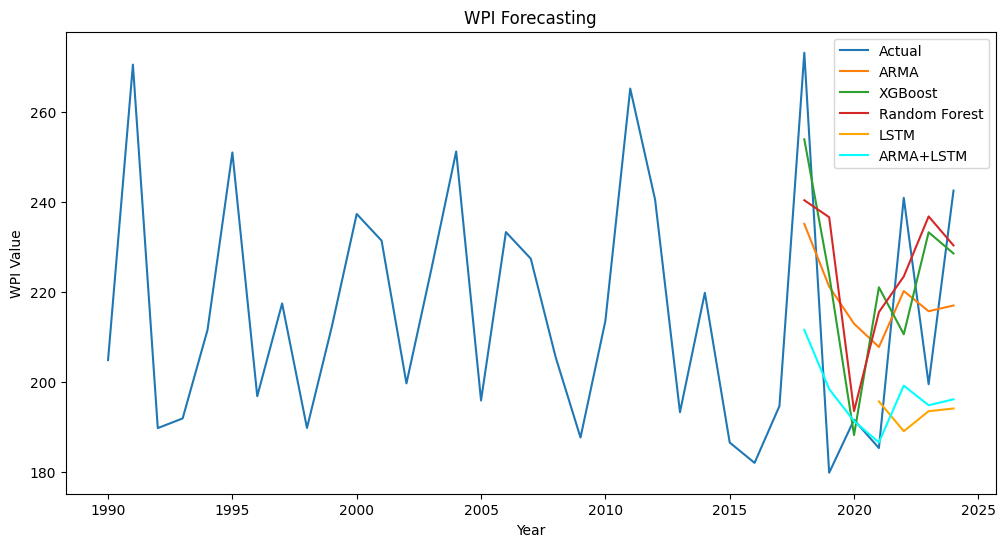

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['WPI'], label='Actual')
plt.plot(test_data.index, arma_forecast, label='ARMA')
plt.plot(test_data.index, xgb_forecast, label='XGBoost')
plt.plot(test_data.index, rf_forecast, label='Random Forest')
plt.plot(test_data.index[-len(test_predictions):], test_predictions, label='LSTM', color='orange')
plt.plot(test_data.index, hybrid_forecast, label='ARMA+LSTM', color='cyan')
plt.xlabel('Year')
plt.ylabel('WPI Value')
plt.legend()
plt.title('WPI Forecasting')
plt.show()

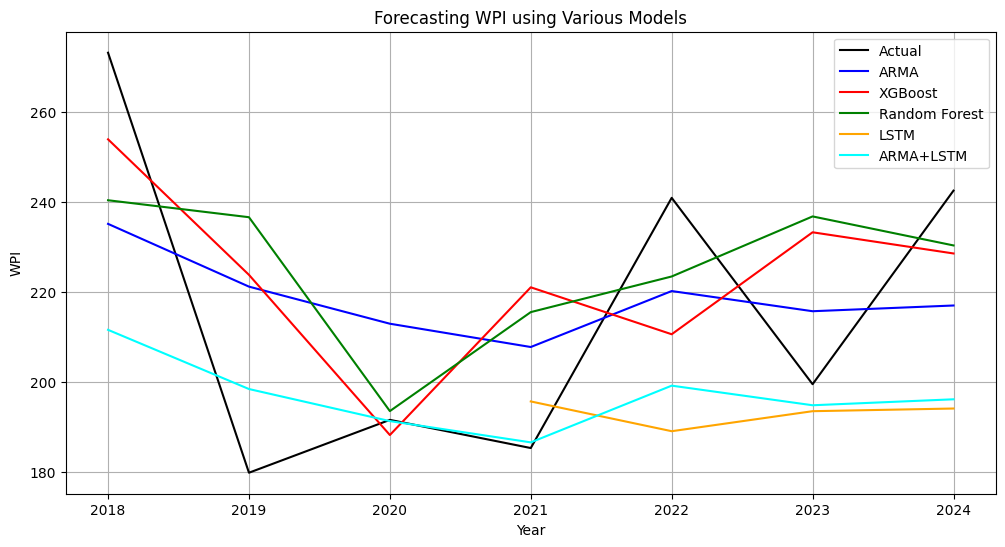

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='black')
plt.plot(test_data.index, arma_forecast, label='ARMA', color='blue')
plt.plot(test_data.index, xgb_forecast, label='XGBoost', color='red')
plt.plot(test_data.index, rf_forecast, label='Random Forest', color='green')
plt.plot(test_data.index[-len(test_predictions):], test_predictions, label='LSTM', color='orange')
plt.plot(test_data.index, hybrid_forecast, label='ARMA+LSTM', color='cyan')

plt.xlabel('Year')
plt.ylabel('WPI')
plt.title('Forecasting WPI using Various Models')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

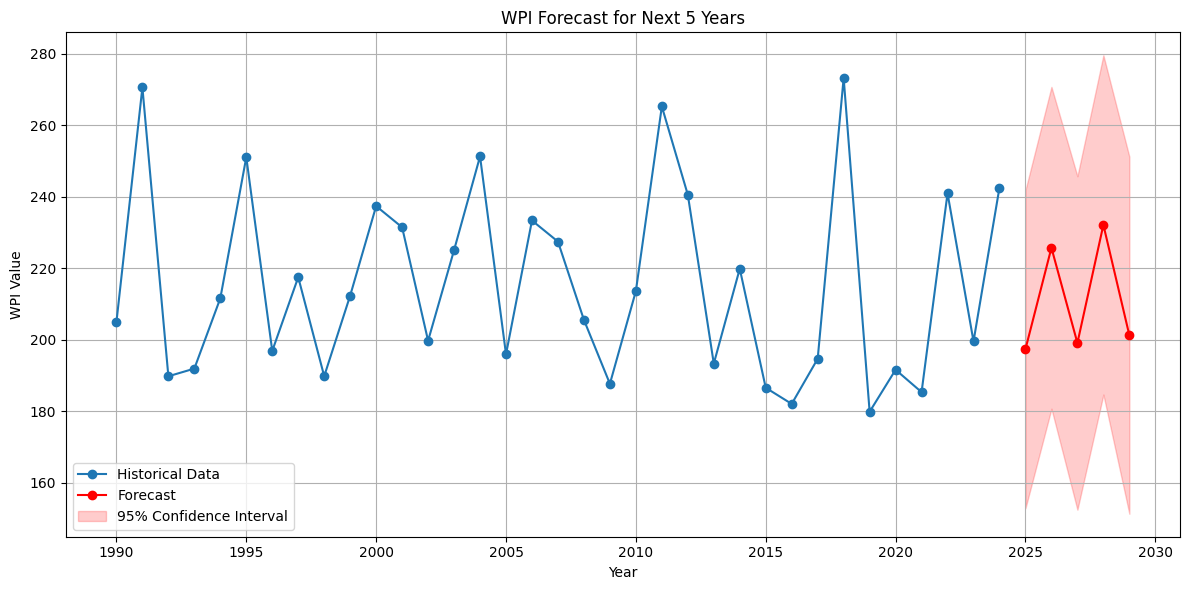


Forecasted values for the next 5 years:
Year 2025: 197.3289
Year 2026: 225.6912
Year 2027: 199.0501
Year 2028: 232.0964
Year 2029: 201.2194


In [ ]:
model = ARIMA(df['WPI'], order=(3,0,1))
results = model.fit()

# Forecasting for the next 5 years
forecast_steps = 5
forecast = results.forecast(steps=forecast_steps)

last_year = df.index[-1]

forecast_index = range(last_year + 1, last_year + forecast_steps + 1)

forecast = np.array(forecast)

# 95% Confidence intervals
forecast_ci = results.get_forecast(steps=forecast_steps).conf_int(alpha=0.05)
lower_ci = forecast_ci.iloc[:, 0]
upper_ci = forecast_ci.iloc[:, 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['WPI'], label='Historical Data', marker='o')
plt.plot(forecast_index, forecast, label='Forecast', color='red', marker='o')
plt.fill_between(forecast_index, lower_ci, upper_ci, color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('WPI Forecast for Next 5 Years')
plt.xlabel('Year')
plt.ylabel('WPI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecasted values
print("\nForecasted values for the next 5 years:")
for i, year in enumerate(forecast_index):
    print(f"Year {year}: {forecast[i]:.4f}")